Install dependencies

In [ ]:
%pip install torchkeras
%pip install accelerate
%pip install captum
%pip install scanpy
%pip install loguru
%pip install transformers==4.30.2

## Part 1 Build a basic neural network model

Here we use simple MLP model as an example. 

In [1]:
import os
import sys
import math
import torch
import random
import warnings
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# sys.path.append('/kaggle/input/utils-file')
# from utils import *


warnings.filterwarnings("ignore")

In [2]:
class MLP(nn.Module):
    # A simple MLP example
    def __init__(self, d_input, d_hidden, d_output):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(d_input, d_hidden)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(d_hidden, d_output)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [3]:
mlp = MLP(d_input=128, d_hidden=64, d_output=2)
print(mlp)

MLP(
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=64, out_features=2, bias=True)
)


In [4]:
class TransformerEncoderLayer(nn.Module):
    # TransformerEncoderLayer is made up of self-attn and feed forward (defined below)
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward  # Here is an instance of the FFN
        self.res_layers = clones(ResConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.res_layers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.res_layers[1](x, self.feed_forward)

## Part 2 Train a toy Transformer model for string summation

Here we will use Transformer to do a simple task: computing numerical summation from strings of numbers.

In [5]:
import torch
from utils import *
from torch.optim import Adam
from torchmetrics import Accuracy 
from torchkeras import KerasModel
from torch.utils.data import Dataset, DataLoader

2025-06-18 08:58:45.964083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750237126.166954      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750237126.227929      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 3.1 Define vocabulary and dataset

In [6]:
# vocabulary for input sequence
words_x = '<PAD>,1,2,3,4,5,6,7,8,9,0,<SOS>,<EOS>,+'
vocab_x = {word: i for i, word in enumerate(words_x.split(','))}
vocab_xr = [k for k, v in vocab_x.items()]  # dictionary for reverse lookup

# vocabulary for output sequence
words_y = '<PAD>,1,2,3,4,5,6,7,8,9,0,<SOS>,<EOS>'
vocab_y = {word: i for i, word in enumerate(words_y.split(','))}
vocab_yr = [k for k, v in vocab_y.items()]  # dictionary for reverse lookup


def get_data():
    words = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    p = np.array([7, 5, 5, 7, 6, 5, 7, 6, 5, 7])
    p = p / p.sum()

    # randomly sample n1 words as the first addition number
    n1 = random.randint(10, 20)
    s1 = np.random.choice(words, size=n1, replace=True, p=p)
    s1 = s1.tolist()

    # randomly sample n2 words as the second addition number
    n2 = random.randint(10, 20)
    s2 = np.random.choice(words, size=n2, replace=True, p=p)
    s2 = s2.tolist()

    # the input sequence
    x = s1 + ['+'] + s2
    
    # the ground truth output sequence
    y = int(''.join(s1)) + int(''.join(s2))
    y = list(str(y))
    
    # add start of sentence (SOS) and end of sentence (EOS)
    x = ['<SOS>'] + x + ['<EOS>']
    y = ['<SOS>'] + y + ['<EOS>']

    # use <PAD> to ensure fixed sequence length
    x = x + ['<PAD>'] * 50
    y = y + ['<PAD>'] * 51
    x = x[:50]
    y = y[:51]

    # tokenization: transform words into id
    token_x = [vocab_x[i] for i in x]
    token_y = [vocab_y[i] for i in y]

    # convert to tensor
    tensor_x = torch.LongTensor(token_x)
    tensor_y = torch.LongTensor(token_y)
    return tensor_x, tensor_y


class TwoSumDataset(Dataset):
    def __init__(self, size=100000):
        super(Dataset, self).__init__()
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        return get_data()


ds_train = TwoSumDataset(size=100000)
ds_val = TwoSumDataset(size=10000)
dl_train = DataLoader(dataset=ds_train, batch_size=200, drop_last=True, shuffle=True)
dl_val = DataLoader(dataset=ds_val, batch_size=200, drop_last=True, shuffle=False)

### 3.2 Initialize a Transformer model

In [7]:
KerasModel.StepRunner = StepRunner
net = Transformer.from_config(src_vocab=len(vocab_x), tgt_vocab=len(vocab_y), N=5, d_model=64, d_ff=128, h=8, dropout=0.1)
loss_fn = LabelSmoothingLoss(size=len(vocab_y), padding_idx=0, smoothing=0.1)
metrics_dict = {'acc': Accuracy(task='multiclass', num_classes=len(vocab_y))} 
optimizer = NoamOpt(net.parameters(), model_size=64)

### 3.3 Train and test the Transformer model

Typically train such a model takes about 0.5-1 hour on an Nvidia A100 80G GPU. Due to limitation of computational resources, we set training epochs as 1 as a demonstration, and use pretrained model weights for model testing.

<<<<<< ⚡️ cuda is used >>>>>>


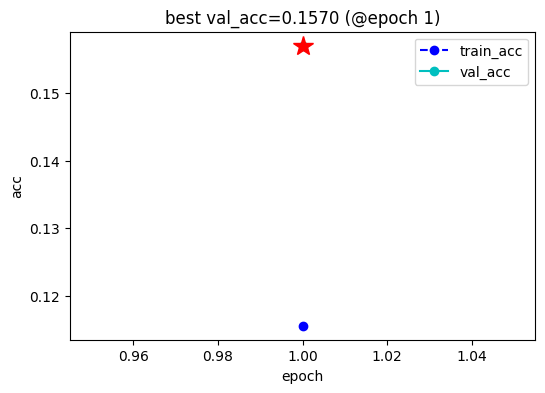

,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,1.936962,0.115523,0.000247,1.757492,0.157036


In [8]:
model = KerasModel(net, loss_fn=loss_fn, metrics_dict=metrics_dict, optimizer=optimizer)
model.fit(
    train_data=dl_train, val_data=dl_val,
    epochs=1, ckpt_path='checkpoint', patience=10,  # if you wish to train from scratch, change epochs to 100 and try it later
    monitor='val_acc', mode='max',
    callbacks=None, plot=True
)

Here we provided the pretrained weights of the Transformer model, which is trained under 100 epochs.

In [9]:
model.load_ckpt("/kaggle/input/sum-ckpt/pytorch/default/1/sum-ckpt.pth")
net = model.net
net.eval()

def prepare(x, accelerator=model.accelerator):
    return x.to(accelerator.device)

net = prepare(net)
src, tgt = get_data()
src, tgt = prepare(src), prepare(tgt)
mbatch = MaskedBatch(src=src.unsqueeze(dim=0), tgt=tgt.unsqueeze(dim=0))

y_pred = greedy_decode(net, mbatch.src, mbatch.src_mask, 50, vocab_y["<SOS>"])
print("input:")
print(get_words(mbatch.src[0], vocab_xr),'\n')
print("ground truth:")
print(get_words(mbatch.tgt[0], vocab_yr),'\n')
print("prediction:")
print(get_words(y_pred[0], vocab_yr))

input:
2379867372359540300+880945029912 

ground truth:
2379868253304570212 

prediction:
2379868253304570212


## Part 3 Install and use pretrained LCM for cell type annotation

Here, we use scMulan to annotate cell types in Heart, Lung, Liver, Bone marrow, Blood, Brain, and Thymus. 

We provide a liver dataset sampled (percentage of 20%) from Suo C, 2022 (doi/10.1126/science.abo0510), which can be downloaded from https://cloud.tsinghua.edu.cn/f/45a7fd2a27e543539f59/?dl=1.

Pretrained model weights of scMulan can be downloaded from https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1.

In [ ]:
sys.path.append("/kaggle/input/scmulan")
import scMulan
import scanpy as sc
from scMulan import GeneSymbolUniform

### 3.1 Load the .h5ad file of the liver dataset
It's recommended that you use h5ad here with raw count (and after your QC). Here we directly load adata with processed gene symbols. Due to limitation of computational resources, we use a 5% subsampled dataset as a demonstration.

In [ ]:
adata_GS_uniformed = sc.read_h5ad('/kaggle/input/liver-uniformed-subsampled/liver_uniformed_subsampled.h5ad')

In [ ]:
adata_GS_uniformed

In [ ]:
# norm and log1p count matrix
if adata_GS_uniformed.X.max() > 10:
    sc.pp.normalize_total(adata_GS_uniformed, target_sum=1e4) 
    sc.pp.log1p(adata_GS_uniformed)

### 3.2 Launch the pretrained scMulan model

In [ ]:
# you should first download ckpt from https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1
# put it under .ckpt/ckpt_scMulan.pt
# by: wget https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1  -O ckpt/ckpt_scMulan.pt

ckp_path = '/kaggle/input/scmulan-ckpt/pytorch/default/1/ckpt_scMulan.pth'
meta_info_path = '/kaggle/input/scmulan/scMulan/utils/meta_info.pt'

In [ ]:
scml = scMulan.model_inference(ckp_path, adata_GS_uniformed, meta_info_path=meta_info_path)
base_process = scml.cuda_count()

In [ ]:
scml.get_cell_types_and_embds_for_adata(parallel=True, n_process = base_process)

The predicted cell types are stored in scml.adata.obs['cell_type_from_scMulan'], besides the cell embeddings (for multibatch integration) in scml.adata.obsm['X_scMulan'] (not used in this tutorial).

### 3.3 Visualize the cell type annotation results of scMulan

In [ ]:
adata_mulan = scml.adata.copy()

In [ ]:
sc.pp.pca(adata_mulan)
sc.pp.neighbors(adata_mulan, n_pcs=10)
sc.tl.umap(adata_mulan)

In [ ]:
# you can run smoothing function to filter the false positives
scMulan.cell_type_smoothing(adata_mulan, threshold=0.1)

In [ ]:
# cell_type_from_scMulan: pred
# cell_type_from_mulan_smoothing: pred+smoothing
# original_name: original annotations by the authors
# cell_type: cell types in hECA-10M that maps original_name to uHAF

sc.pl.umap(adata_mulan,color=["cell_type_from_scMulan","cell_type_from_mulan_smoothing",
                              'cell_type','original_name'],ncols=1)